1) 用 Word2vec 模型（自己训练的和rusvectores的）向量化文本，根据重述定义在所得向量上训练2个模型，找到最好的模型。

Обучите 2 модели по определению перефразирования на получившихся векторах
Word2Vec要在另外的库训练（不在平行句子上），可以选用课堂上的数据或其它的

要用cross-validation评价模型，кросс-валидации! Метрика - f1

2) 分别用5种方法训练成对的文本向量：SVD, NMF, Word2Vec (自己的和rucvectores的), Fastext. 
数据库的每行应有五对向量。在每对向量之间计算余弦相似度（一对5个） 

通过这些相似度建立训练样本。在此样本上训练任何一个模型（Logreg，Random Forest或其他），
并评估cross-validation(交叉验证)的质量（使用micro-f1-measure）。
尝试通过更改向量化时的参数来改进指标。

SVD 和 NMF 直接应用于数据,  w2w 和 fastext 在其他库训练（与第一问一样） 

Выложите код к себе на гитхаб и вставьте ссылку в поле ниже (в тетрадке должны быть показатели метрик и ваши комментарии).


In [2]:
import pandas as pd
from lxml import html
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD, NMF, PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_distances
from sklearn.ensemble import RandomForestClassifier
import gensim
from sklearn.cluster import MiniBatchKMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter,defaultdict
from string import punctuation
import os
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
%matplotlib inline

morph = MorphAnalyzer()
punct = punctuation+'«»—…“”*№–'
stops = set(stopwords.words('russian'))

In [3]:
def normalize(text):
    
    words = [word.strip(punct) for word in text.lower().split()]
    words = [morph.parse(word)[0].normal_form for word in words if word and word not in stops]

    return ' '.join(words)

def tokenize(text):
    
    words = [word.strip(punct) for word in text.lower().split()]

    return ' '.join(words)

## corpus_hum

In [5]:
data = open('corpus_hum.txt', encoding="utf-8").read().splitlines()
data_norm = [normalize(text) for text in data]
data_norm = [text for text in data_norm if text]

In [83]:
data_norm[:2]

['абай василий васо иван 1900–2001 русский лингвист родиться 2 15 декабрь 1900 с.коби тифлисский губерния ныне грузия 1925 окончить факультет общественный наука ленинградский университет 1928 аспирантура 1928–1930 сотрудник кавказский историко-археологический институт ан ссср 1930 полвека работать яфетический институт затем институт язык мышление институт языкознание ан ссср ленинград 1950 москва доктор филологический наука 1962 профессор 1969 лауреат государственный премия ссср 1981 почётный член азиатский королевский общество великобритания ирландия 1966 член-корреспондент финно-угорский общество хельсинки 1973 умереть абай москва 18 март 2001',
 'также тема']

In [7]:
len(data_norm)

115082

In [8]:
cv = CountVectorizer(min_df=3, max_df=0.4, max_features=1000)
X = cv.fit_transform(data_norm)

In [9]:
X.shape

(115082, 1000)

### SVD & NMF

In [10]:
svd = TruncatedSVD(4)
svd.fit(X)
tsne = TSNE(2).fit_transform(svd.components_.T)

In [11]:
id2word = {i:w for i,w in enumerate(cv.get_feature_names())}
word2id = {w:i for i,w in id2word.items()}

In [13]:
nmf = NMF(50)
nmf.fit(X)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=50, random_state=None, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [14]:
svd = TruncatedSVD(50)
svd.fit(X)

TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
             random_state=None, tol=0.0)

In [15]:
id2vec_svd = nmf.components_.T

In [16]:
id2vec_nmf = svd.components_.T

In [17]:
def most_similar(word, id2vec):
    similar = [id2word[i] for i in cosine_distances(id2vec[word2id[word]].reshape(1, -1), id2vec).argsort()[0][:10]]
    return similar

In [24]:
cluster_svd = MiniBatchKMeans(30, n_init=3, verbose=1, max_no_improvement=100, reassignment_ratio=0.4)
cluster_svd.fit(svd.components_.T)

Init 1/3 with method: k-means++
Inertia for init 1/3: 7.847001
Init 2/3 with method: k-means++
Inertia for init 2/3: 9.277354
Init 3/3 with method: k-means++
Inertia for init 3/3: 7.719683
Minibatch iteration 1/1000: mean batch inertia: 0.026884, ewa inertia: 0.026884 
Minibatch iteration 2/1000: mean batch inertia: 0.035086, ewa inertia: 0.028523 
Minibatch iteration 3/1000: mean batch inertia: 0.049890, ewa inertia: 0.032792 
Minibatch iteration 4/1000: mean batch inertia: 0.038418, ewa inertia: 0.033916 
Minibatch iteration 5/1000: mean batch inertia: 0.021644, ewa inertia: 0.031464 
Minibatch iteration 6/1000: mean batch inertia: 0.020122, ewa inertia: 0.029198 
Minibatch iteration 7/1000: mean batch inertia: 0.050604, ewa inertia: 0.033475 
Minibatch iteration 8/1000: mean batch inertia: 0.029602, ewa inertia: 0.032701 
Minibatch iteration 9/1000: mean batch inertia: 0.033506, ewa inertia: 0.032862 
[MiniBatchKMeans] Reassigning 29 cluster centers.
Minibatch iteration 10/1000: mea

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=100,
                n_clusters=30, n_init=3, random_state=None,
                reassignment_ratio=0.4, tol=0.0, verbose=1)

In [25]:
cls_svd = defaultdict(list)

for i, cl in enumerate(cluster_svd.labels_):
    cls_svd[cl].append(id2word[i])

f = open('cluster_svd.txt', 'w')
for cl in cls_svd:
    f.write('### '+ str(cl) + ' ###\n')
    f.write('\n'.join(cls_svd[cl]))
    f.write('\n\n')
f.close()

In [26]:
cluster_nmf = MiniBatchKMeans(40, n_init=3, verbose=1, max_no_improvement=100, reassignment_ratio=0.5)
cluster_nmf.fit(nmf.components_.T)

Init 1/3 with method: k-means++
Inertia for init 1/3: 1934.028094
Init 2/3 with method: k-means++
Inertia for init 2/3: 963.635824
Init 3/3 with method: k-means++
Inertia for init 3/3: 1376.979588
Minibatch iteration 1/1000: mean batch inertia: 16.652668, ewa inertia: 16.652668 
Minibatch iteration 2/1000: mean batch inertia: 13.113488, ewa inertia: 15.945539 
Minibatch iteration 3/1000: mean batch inertia: 7.904567, ewa inertia: 14.338951 
Minibatch iteration 4/1000: mean batch inertia: 9.932406, ewa inertia: 13.458523 
Minibatch iteration 5/1000: mean batch inertia: 7.350332, ewa inertia: 12.238105 
Minibatch iteration 6/1000: mean batch inertia: 12.477005, ewa inertia: 12.285837 
Minibatch iteration 7/1000: mean batch inertia: 3.562819, ewa inertia: 10.542976 
Minibatch iteration 8/1000: mean batch inertia: 8.969881, ewa inertia: 10.228672 
Minibatch iteration 9/1000: mean batch inertia: 10.864403, ewa inertia: 10.355691 
[MiniBatchKMeans] Reassigning 39 cluster centers.
Minibatch i

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=100,
                n_clusters=40, n_init=3, random_state=None,
                reassignment_ratio=0.5, tol=0.0, verbose=1)

In [27]:
cls_nmf = defaultdict(list)

for i, cl in enumerate(cluster_nmf.labels_):
    cls_nmf[cl].append(id2word[i])
# откройте в любом текстовом редакторе
f = open('cluster_nmf.txt', 'w')
for cl in cls_nmf:
    f.write('### '+ str(cl) + ' ###\n')
    f.write('\n'.join(cls_nmf[cl]))
    f.write('\n\n')
f.close()

# w2v

## w2v самостоятельно обученная (лучше)

In [31]:
corpus_xml = html.fromstring(open('paraphrases.xml', 'rb').read())
texts_1 = []
texts_2 = []
classes = []

for p in corpus_xml.xpath('//paraphrase'):
    texts_1.append(p.xpath('./value[@name="text_1"]/text()')[0])
    texts_2.append(p.xpath('./value[@name="text_2"]/text()')[0])
    classes.append(p.xpath('./value[@name="class"]/text()')[0])
    
data = pd.DataFrame({'text_1':texts_1, 'text_2':texts_2, 'label':classes})

In [32]:
data['text_1_norm'] = data['text_1'].apply(normalize)
data['text_2_norm'] = data['text_2'].apply(normalize)

In [61]:
data.head(10)

,text_1,text_2,label,text_1_norm,text_2_norm
0,Полицейским разрешат стрелять на поражение по ...,Полиции могут разрешить стрелять по хулиганам ...,0,полицейский разрешить стрелять поражение гражд...,полиция мочь разрешить стрелять хулиган травма...
1,Право полицейских на проникновение в жилище ре...,Правила внесудебного проникновения полицейских...,0,право полицейский проникновение жилища решить ...,правило внесудебный проникновение полицейский ...
2,Президент Египта ввел чрезвычайное положение в...,Власти Египта угрожают ввести в стране чрезвыч...,0,президент египет ввести чрезвычайный положение...,власть египет угрожать ввести страна чрезвычай...
3,Вернувшихся из Сирии россиян волнует вопрос тр...,Самолеты МЧС вывезут россиян из разрушенной Си...,-1,вернуться сирия россиянин волновать вопрос тру...,самолёт мчс вывезти россиянин разрушить сирия
4,В Москву из Сирии вернулись 2 самолета МЧС с р...,Самолеты МЧС вывезут россиян из разрушенной Си...,0,москва сирия вернуться 2 самолёт мчс россиянин...,самолёт мчс вывезти россиянин разрушить сирия
5,Приставы соберут отпечатки пальцев российских ...,Приставы снимут отпечатки пальцев у злостных н...,1,пристав собрать отпечаток палец российский дол...,пристав снять отпечаток палец злостный неплате...
6,На саратовского дебошира с борта самолета Моск...,Саратовский дебошир отказывается возвращаться ...,-1,саратовский дебошир борт самолёт москва хургад...,саратовский дебошир отказываться возвращаться ...
7,ЦИК хочет отказаться от электронной системы по...,ЦИК может отказаться от электронных средств по...,0,цик хотеть отказаться электронный система подс...,цик отказаться электронный средство подсчёт голос
8,Суд Петербурга оставил на потом дело о гибели ...,Лондонский Гайд-парк - это не место для митинг...,-1,суд петербург оставить дело гибель подросток п...,лондонский гайд-парк это место митинг прежде парк
9,Страны ОПЕК сократили добычу нефти на 1 млн ба...,Обама продлил полномочия НАСА по сотрудничеств...,-1,страна опека сократить добыча нефть 1 миллион ...,обама продлить полномочие наса сотрудничество ...


In [79]:
w2v = gensim.models.Word2Vec([text.split() for text in data_norm], size=50, sg=1)

In [73]:
def get_embedding(text, model, dim):
    text = text.split()
    
    # чтобы не доставать одно слово несколько раз
    # сделаем счетчик, а потом векторы домножим на частоту
    words = Counter(text)
    total = len(text)
    vectors = np.zeros((len(words), dim))
    
    for i,word in enumerate(words):
        try:
            v = model[word]
            vectors[i] = v*(words[word]/total) # просто умножаем вектор на частоту
        except (KeyError, ValueError):
            continue
    
    if vectors.any():
        vector = np.average(vectors, axis=0)
    else:
        vector = np.zeros((dim))
    
    return vector

In [80]:
dim = 50
X_text_1_w2v = np.zeros((len(data['text_1_norm']), dim))
X_text_2_w2v = np.zeros((len(data['text_2_norm']), dim))

for i, text in enumerate(data['text_1_norm'].values):
    X_text_1_w2v[i] = get_embedding(text, w2v, dim)
    
for i, text in enumerate(data['text_2_norm'].values):
    X_text_2_w2v[i] = get_embedding(text, w2v, dim)

d:\program files\python\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


In [81]:
X_text_w2v = np.concatenate([X_text_1_w2v, X_text_2_w2v], axis=1)

In [87]:
X_text_w2v.shape

(7227, 100)

### cros val

In [86]:
from sklearn.model_selection import cross_val_score

In [37]:
y = data['label'].values
print(y.shape)

(7227,)


In [99]:
train_X, valid_X, train_y, valid_y = train_test_split(X_text_w2v, y,random_state=1)
clf = LogisticRegression(C=1000)
clf.fit(train_X, train_y)
preds = clf.predict(valid_X)
print(classification_report(valid_y, preds))

d:\program files\python\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\program files\python\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


              precision    recall  f1-score   support

          -1       0.48      0.46      0.47       629
           0       0.45      0.67      0.54       737
           1       0.37      0.08      0.13       441

    accuracy                           0.46      1807
   macro avg       0.43      0.41      0.38      1807
weighted avg       0.44      0.46      0.42      1807



In [100]:
cross_val_score(clf, X_text_w2v, y, scoring='f1_micro', cv=10).mean()

d:\program files\python\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\program files\python\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
d:\program files\python\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\program files\python\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
d:\program files\python\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver 

0.4498255886930286

In [93]:
from sklearn.neighbors import KNeighborsClassifier
k_range = range(1,31)
cv_scores = []
for n in k_range:
    knn = KNeighborsClassifier(n)
    scores = cross_val_score(knn, X_text_w2v, y, cv=10,scoring='f1_micro')
    cv_scores.append(scores.mean())

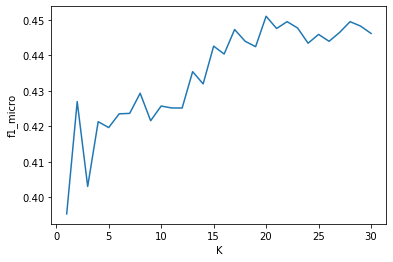

In [94]:
from matplotlib import pyplot as plt
plt.plot(k_range,cv_scores)
plt.xlabel('K')
plt.ylabel('f1_micro')
plt.show()

In [95]:
best_knn = KNeighborsClassifier(n_neighbors=20)
best_knn.fit(train_X,train_y)
print(best_knn.score(valid_X,valid_y))

0.4703929164360819


### 以下为非交叉验证，仅供参考

In [ ]:
# Random Forest
train_X, valid_X, train_y, valid_y = train_test_split(X_text_w2v, y,random_state=1)
clf = RandomForestClassifier(n_estimators=100, max_depth=7, min_samples_leaf=15,
                             class_weight='balanced')
clf.fit(train_X, train_y)
preds = clf.predict(valid_X)
print(classification_report(valid_y, preds))

In [ ]:
# LogReg
train_X, valid_X, train_y, valid_y = train_test_split(X_text_w2v, y,random_state=1)
clf = LogisticRegression(C=1000)
clf.fit(train_X, train_y)
preds = clf.predict(valid_X)
print(classification_report(valid_y, preds))

## w2v rusvectores

In [105]:
data_tag=pd.read_csv('data_paraphraser_norm.csv')

In [111]:
data_tag.head(10)

,label,text_1,text_2,text_1_norm,text_2_norm
0,0,Полицейским разрешат стрелять на поражение по ...,Полиции могут разрешить стрелять по хулиганам ...,полицейский_NOUN разрешать_VERB стрелять_VERB ...,полиция_NOUN мочь_VERB разрешать_VERB стрелять...
1,0,Право полицейских на проникновение в жилище ре...,Правила внесудебного проникновения полицейских...,право_ADV полицейский_NOUN на_ADP проникновени...,правило_NOUN внесудебный_ADJ проникновение_NOU...
2,0,Президент Египта ввел чрезвычайное положение в...,Власти Египта угрожают ввести в стране чрезвыч...,президент_NOUN египет_NOUN вводить_VERB чрезвы...,власть_NOUN египет_NOUN угрожать_VERB вводить_...
3,-1,Вернувшихся из Сирии россиян волнует вопрос тр...,Самолеты МЧС вывезут россиян из разрушенной Си...,вернуться_VERB из_ADP сирия_NOUN россиянин_NOU...,самолет_NOUN мчс_NOUN вывозить_VERB россиянин_...
4,0,В Москву из Сирии вернулись 2 самолета МЧС с р...,Самолеты МЧС вывезут россиян из разрушенной Си...,в_ADP москва_NOUN из_ADP сирия_NOUN вернуться_...,самолет_NOUN мчс_NOUN вывозить_VERB россиянин_...
5,1,Приставы соберут отпечатки пальцев российских ...,Приставы снимут отпечатки пальцев у злостных н...,пристав_NOUN собирать_VERB отпечаток_NOUN пале...,пристав_NOUN снимать_VERB отпечаток_NOUN палец...
6,-1,На саратовского дебошира с борта самолета Моск...,Саратовский дебошир отказывается возвращаться ...,на_ADP саратовский_ADJ дебошир_NOUN с_ADP борт...,саратовский_ADJ дебошир_NOUN отказываться_VERB...
7,0,ЦИК хочет отказаться от электронной системы по...,ЦИК может отказаться от электронных средств по...,цик_NOUN хотеть_VERB отказываться_VERB от_ADP ...,цик_NOUN мочь_VERB отказываться_VERB от_ADP эл...
8,-1,Суд Петербурга оставил на потом дело о гибели ...,Лондонский Гайд-парк - это не место для митинг...,суд_NOUN петербург_NOUN оставлять_VERB на_ADP ...,лондонский_ADJ гайд_NOUN парк_NOUN это_PART не...
9,-1,Страны ОПЕК сократили добычу нефти на 1 млн ба...,Обама продлил полномочия НАСА по сотрудничеств...,страна_NOUN опек_NOUN сокращать_VERB добыча_NO...,обама_NOUN продлять_VERB полномочие_NOUN нас_N...


In [112]:
data_tag['text_1_norm'][0]

'полицейский_NOUN разрешать_VERB стрелять_VERB на_ADP поражение_NOUN по_ADP гражданин_NOUN с_ADP травматика_NOUN'

In [113]:
y_tag = data_tag['label'].values

In [76]:
model = gensim.models.KeyedVectors.load_word2vec_format('model.bin', binary=True)

In [77]:
model.most_similar('февраль_NOUN')

[('март_NOUN', 0.9544488191604614),
 ('апрель_NOUN', 0.9534032344818115),
 ('ноябрь_NOUN', 0.9383174777030945),
 ('октябрь_NOUN', 0.9273386597633362),
 ('декабрь_NOUN', 0.9178366661071777),
 ('июнь_NOUN', 0.916779637336731),
 ('май_NOUN', 0.9141846895217896),
 ('сентябрь_NOUN', 0.9087847471237183),
 ('август_NOUN', 0.9031303524971008),
 ('январь_NOUN', 0.8994792699813843)]

In [107]:
dim = 50
X_text_1_rv = np.zeros((len(data_tag['text_1_norm']), dim))
X_text_2_rv = np.zeros((len(data_tag['text_2_norm']), dim))

for i, text in enumerate(data_tag['text_1_norm'].values):
    X_text_1_rv[i] = get_embedding(text, model, dim)
    
for i, text in enumerate(data_tag['text_2_norm'].values):
    X_text_2_rv[i] = get_embedding(text, model, dim)

In [108]:
X_text_rv = np.concatenate([X_text_1_rv, X_text_2_rv], axis=1)

In [114]:
train_X, valid_X, train_y, valid_y = train_test_split(X_text_rv, y_tag,random_state=1)
clf = LogisticRegression(C=1000)
clf.fit(train_X, train_y)
preds = clf.predict(valid_X)
print(classification_report(valid_y, preds))

d:\program files\python\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\program files\python\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
d:\program files\python\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       629
           0       0.41      1.00      0.58       737
           1       0.00      0.00      0.00       441

    accuracy                           0.41      1807
   macro avg       0.14      0.33      0.19      1807
weighted avg       0.17      0.41      0.24      1807



In [115]:
cross_val_score(clf, X_text_rv, y_tag, scoring='f1_micro', cv=10).mean()

d:\program files\python\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\program files\python\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
d:\program files\python\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
d:\program files\python\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
d:\program files\python\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver 

0.40916010007067494

# 2 часть

In [127]:
tfidf = TfidfVectorizer(min_df=3, max_df=0.4, max_features=1000)
tfidf.fit(pd.concat([data['text_1_norm'], data['text_2_norm']]))

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.4, max_features=1000,
                min_df=3, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

## SVD

In [128]:
svd = TruncatedSVD(200)

X_text_1_svd = svd.fit_transform(tfidf.transform(data['text_1_norm']))
X_text_2_svd = svd.fit_transform(tfidf.transform(data['text_2_norm']))

X_text_svd = np.concatenate([X_text_1_svd, X_text_2_svd], axis=1)

In [129]:
X_text_svd.shape

(7227, 400)

### cos similarity

In [51]:
from sklearn.metrics.pairwise import cosine_similarity

In [44]:
# id2vec_svd1 = X_text_1.T
# id2vec_svd2 = X_text_2.T

In [130]:
cos_sim_svd = [cosine_similarity(v.reshape(1, -1), X_text_2_svd[i].reshape(1, -1)).tolist()[0][0] for i, v in enumerate(X_text_1_svd)]

In [132]:
cos_sim_svd[:10]

[-0.06441175922144012,
 0.01829075058195688,
 0.050229458401730945,
 -0.10377657305298164,
 -0.1103977943571668,
 0.007383872254929836,
 -0.056426303499369834,
 -0.017098420656201447,
 0.006976219517873194,
 0.014941552134898641]

## NMF

In [133]:
nmf = NMF(200)

X_text_1_nmf = nmf.transform(tfidf.transform(data['text_1_norm']))
X_text_2_nmf = nmf.transform(tfidf.transform(data['text_2_norm']))

X_text_nmf = np.concatenate([X_text_1_nmf, X_text_2_nmf], axis=1)

NotFittedError: This NMF instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

### косинусная близость

In [67]:
cos_sim_nmf = [cosine_similarity(v.reshape(1, -1), X_text_2_nmf[i].reshape(1, -1)).tolist()[0][0] for i, v in enumerate(X_text_1_nmf)]

In [68]:
cos_sim_nmf[:10]

[0.8565607377206113,
 0.36964653977640455,
 0.7807633195813233,
 0.4087839826071128,
 0.23797067697922028,
 0.05018703371798052,
 0.3644721493031122,
 0.3489559973434516,
 0.08092123044334286,
 0.02661114718782815]

## W2V самостоятельно обученная

In [121]:
cos_sim_w2v = [cosine_similarity(v.reshape(1, -1), X_text_2_w2v[i].reshape(1, -1)).tolist()[0][0] for i, v in enumerate(X_text_1_w2v)]
cos_sim_w2v[:10]

[0.9093553040093278,
 0.9162935532635855,
 0.9508713657789876,
 0.7610319787133144,
 0.9083803325663123,
 0.9244763677726099,
 0.691226839678667,
 0.9688288204766886,
 0.7165422628726466,
 0.7288469007395649]

## W2V rusvectores

In [119]:
cos_sim_rv = [cosine_similarity(v.reshape(1, -1), X_text_2_rv[i].reshape(1, -1)).tolist()[0][0] for i, v in enumerate(X_text_1_rv)]
cos_sim_rv[:10]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

## FastText

In [135]:
fast_text = gensim.models.FastText([text.split() for text in data_norm], size=50, min_n=4, max_n=8)

In [136]:
dim = 50
data['text_1_notnorm'] = data['text_1'].apply(tokenize)
data['text_2_notnorm'] = data['text_2'].apply(tokenize)

X_text_1_ft = np.zeros((len(data['text_1_notnorm']), dim))
X_text_2_ft = np.zeros((len(data['text_2_notnorm']), dim))

for i, text in enumerate(data['text_1_notnorm'].values):
    X_text_1_ft[i] = get_embedding(text, fast_text, dim)
    
for i, text in enumerate(data['text_2_notnorm'].values):
    X_text_2_ft[i] = get_embedding(text, fast_text, dim)

d:\program files\python\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


In [138]:
cos_sim_ft = [cosine_similarity(v.reshape(1, -1), X_text_2_ft[i].reshape(1, -1)).tolist()[0][0] for i, v in enumerate(X_text_1_ft)]
cos_sim_ft[:10]

[0.8030769453455194,
 0.7447322572955146,
 0.6308851035754462,
 0.3842010740534307,
 0.265047370047229,
 0.7304068289115696,
 0.4336536261772452,
 0.8857981894785179,
 0.2316844764635385,
 0.10900673113157934]